## Predicting tutor demand in hours/week 

In [30]:
# import necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance


from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve

from scipy import stats
from scipy.stats import spearmanr

In [62]:
# read in data generated in tutor_cleaning
df_eng = pd.read_csv('/Users/NewUser/Documents/GitHub/tutor_prediction/tutor_prediction/data/tutor_data.csv').drop(columns='Unnamed: 0')
df_eng.reset_index(drop=True, inplace=True)

# read in features engineered in tutor_nlp
df_nlp = pd.read_csv('/Users/NewUser/Documents/GitHub/tutor_prediction/tutor_prediction/data/tutor_nlp.csv')
df_eng = pd.concat([df_eng, df_nlp], axis=1)

# cuts on targets

#df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] < 20].index]
df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] > 0.3].index]
#df_eng = df_eng.loc[df_eng[df_eng['hours_tutor'] <= 1000].index]

#df_eng = df_eng.loc[df_eng[df_eng['rate'] <= 200].index]
#df_eng = df_eng.loc[df_eng[df_eng['rate'] >= 20].index]
#df_eng.drop_duplicates(inplace=True)

In [63]:
df_eng['hours_per_week_estimate'].describe()

count    3685.000000
mean        3.637233
std        11.071156
min         0.300358
25%         0.847335
50%         1.832830
75%         4.052632
max       532.000000
Name: hours_per_week_estimate, dtype: float64

#### histogram and kernel density distribution for demand

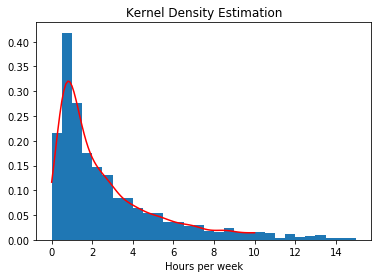

In [64]:
plt.hist(df_eng.hours_per_week_estimate, bins=30, range=(0,15), density=True)
plt.xlabel('Hours per week')
gkde = stats.gaussian_kde(df_eng.hours_per_week_estimate, bw_method = 0.04, weights=None)
ind = np.linspace(0,10,101)
kdepdf = gkde.evaluate(ind)
plt.plot(ind, kdepdf, label='kde', color="r")
plt.title('Kernel Density Estimation')
#plt.legend()
plt.savefig('kde-demand.png', dpi=100)
plt.show()

### Now engineer relevant features from subjects, education such as number_popular_subjects, top_school, etc.

In [65]:
# use function to parse lists typecast as strings from scraped data
def string_to_list(i):
    x = i.replace('[', '').replace(']', '').replace('\'', '').split(',')
    list_i = list()
    for j in x:
        list_i.append(j.lstrip().rstrip())
    return list_i

subjects_all_list = []
for i in df_eng['subjects_all']:
    subjects_all_list.append(string_to_list(i))
df_eng['subjects_list'] = np.array(subjects_all_list)

subjects_emph_list = []
for i in df_eng['subjects_emph']:
    subjects_emph_list.append(string_to_list(i))
df_eng['subjects_emph_list'] = np.array(subjects_emph_list)

#edu_list = []
#for i in df_eng['edu']:
#    edu_list.append(string_to_list(i))
#df_eng['edu_list'] = np.array(edu_list)

# subjects categories based on popularity
feature = 'subjects_list'
size_subjects = len(df_eng[feature].explode().value_counts().index)
popular_subjects = list(df_eng[feature].explode().value_counts().index[:size_subjects//3])
mid_subjects = list(df_eng[feature].explode().value_counts().index[size_subjects//3:(size_subjects//3 + size_subjects//3)])
unpopular_subjects = list(df_eng[feature].explode().value_counts().index[(size_subjects//3 + size_subjects//3):])

# remove unwanted subjects
unwanted = ''
if unwanted in popular_subjects:
    popular_subjects.remove(unwanted)
elif unwanted in mid_subjects:
    mid_subjects.remove(unwanted)
elif unwanted in unpopular_subjects:
    unpopular_subjects.remove(unwanted)
    
# engineer subject features based on popularity
popular_list = []
mid_list = []
unpopular_list = []
for f in df_eng[feature]:
    num_popular = 0
    num_mid = 0
    num_unpopular = 0
    for j in f:
        if j in popular_subjects:
            num_popular += 1
        elif j in mid_subjects:
            num_mid += 1
        elif j in unpopular_subjects:
            num_unpopular += 1
    popular_list.append(num_popular)
    mid_list.append(num_mid)
    unpopular_list.append(num_unpopular)

df_eng['num_popular_subjects'] = np.array(popular_list)
df_eng['num_mid_subjects'] = np.array(mid_list)
df_eng['num_unpopular_subjects'] = np.array(unpopular_list)

# engineer edu degree categories
undergrad = ['BA', 'B.A.', 'BS', 'B.S.', '']
postgrad = ['MS', 'M.S', 'MA', 'M.A', 'masters', 'Masters', 'CA', 'C.A', 
            'MBA', 'M.B.A', 'MD', 'M.D', 'PhD', 'Ph.D', 'Ph.D.', 'Graduate']
certified = ['education', 'Ced', 'certified']

undergrad_degree = []
postgrad_degree = []
certified_degree = []
for e in df_eng['edu']:
    undergrad_count = 0
    postgrad_count = 0
    certified_count = 0
    if any(x in e for x in undergrad):
        undergrad_count += 1
    if any(x in e for x in postgrad):
        postgrad_count += 1
    if any(x in e for x in certified):
        certified_count +=1
    undergrad_degree.append(undergrad_count)
    postgrad_degree.append(postgrad_count)
    certified_degree.append(certified_count)
df_eng['undergrad_degree'] = np.array(undergrad_degree)
df_eng['postgrad_degree'] = np.array(postgrad_degree)
df_eng['certified_degree'] = np.array(certified_degree)

# get university rankings, using WUR dataset in csv
df_wur = pd.read_csv('/Users/NewUser/Documents/GitHub/tutor_prediction/tutor_prediction/data/world-university-rankings_cwurData.csv')
df_wur_select = df_wur[['institution', 'world_rank']]

list_of_top_schools = (list(df_wur_select['institution'][:30]) + 
['Berkeley', 'Caltech', 'Harvard', 'Yale', 'Princeton', 'MIT', 'Stanford'])

# engineer top school feature
top_school = []
for e in df_eng['edu']:
    top = 0
    if any(x in e for x in list_of_top_schools):
        top += 1
    top_school.append(top)
df_eng['top_school'] = np.array(top_school)

df_eng['bio_count'] = df_eng['bio'].apply(lambda x: len(str(x).split(" ")))
df_eng['desc_count'] = df_eng['descriptions'].apply(lambda x: len(str(x).split(" ")))

### drop undesired columns, generate feature matrix X and target y

In [66]:
cols_to_drop = ['descriptions', 'bio', 'subjects_list', 'subjects_emph_list', 
                'edu', 'bg_check_date', 'earliest_review_date', 
                'subjects_emph', 'subjects_all','hours_tutor', 
                'num_ratings', 'review_dates', 'earliest_date','undergrad_degree',
               'hours_mon', 'hours_tues', 'hours_wed', 'hours_thurs', 'hours_fri']

X = df_eng.drop(columns=(['hours_per_week_estimate'] + cols_to_drop))
y = df_eng.hours_per_week_estimate

# Take the log of y
y_log = np.log10(y)

# rescale data
X = (X - X.min()) / (X.max()-X.min())

features = X.columns

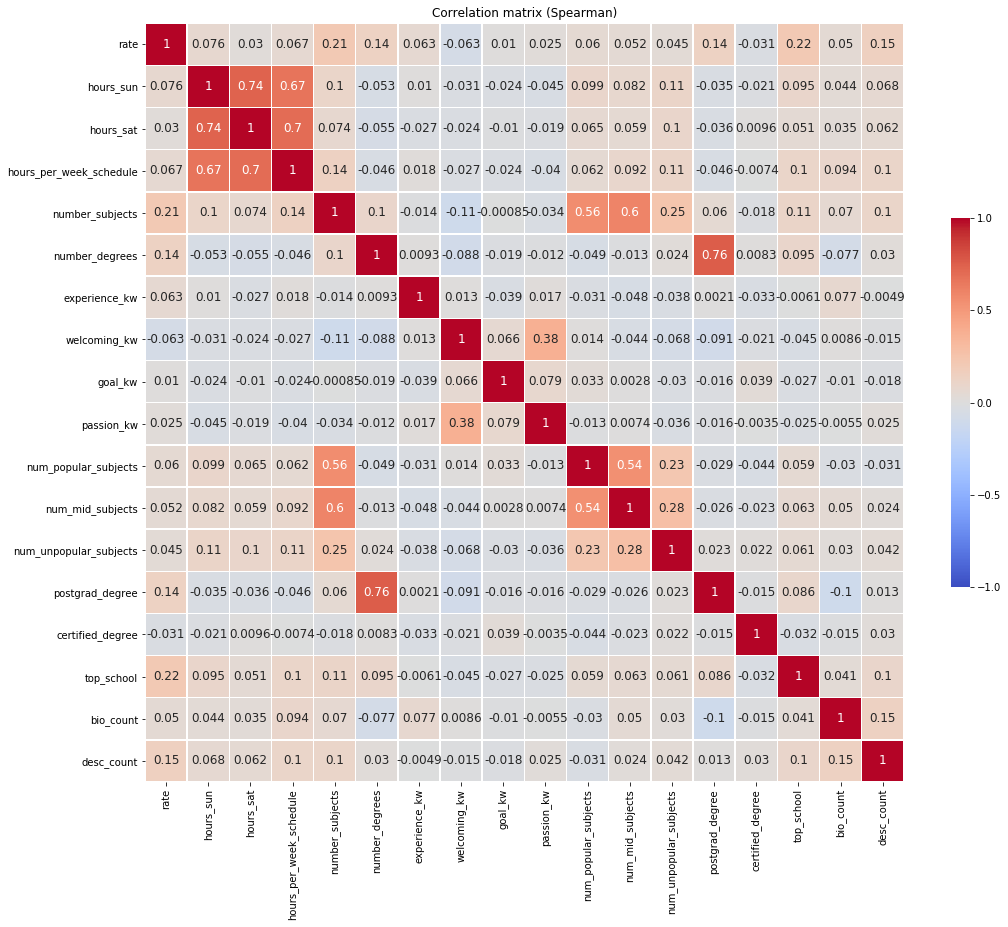

In [67]:
# Plot Spearman Correlation matrix

fig, ax = plt.subplots(figsize=(17, 17)) 

spearman_corr = pd.DataFrame(spearmanr(X).correlation, index=features, columns=features)

spearman_heatmap = sns.heatmap(spearman_corr,
                     square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
ax.set_yticklabels(spearman_corr.columns, rotation = 0)
ax.set_xticklabels(spearman_corr.columns)
ax.set_title('Correlation matrix (Spearman)')
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
fig = spearman_heatmap.get_figure()
fig.savefig('corr-plot.png', dpi=100)

#### First fit a regularized regression model 

r^2:  0.07820692847244914


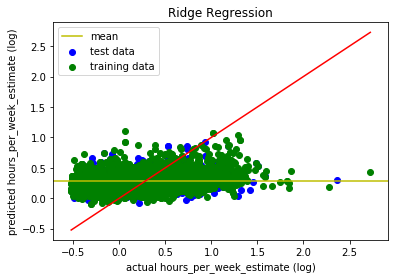

In [68]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
reg_model = Ridge(alpha=1e-2).fit(X_train, y_train)
y_predict = reg_model.predict(X_test)
y_fit = reg_model.predict(X_train)

# get r^2 score, scatterplot of actual target, predicted target and mean
print('r^2: ', r2_score(y_test, y_predict))

plt.scatter(np.array(y_test), y_predict, color='b', label='test data')
plt.scatter(np.array(y_train), y_fit, color='g', label='training data')
plt.axhline(y=y_log.mean(), color='y', linestyle='-', label='mean')
x = np.linspace(y_log.min(), y_log.max(),100)
plt.plot(x, x, '-r')
plt.legend()
plt.title('Ridge Regression')
plt.xlabel('actual hours_per_week_estimate (log)')
plt.ylabel('predicted hours_per_week_estimate (log)')
plt.show()

### Now try a random forest regressor

r^2:  0.17305979381314807


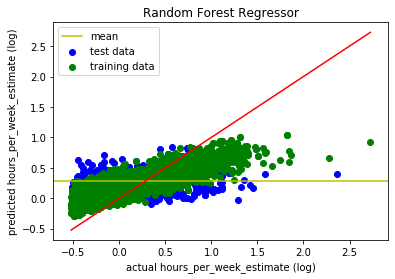

In [69]:
# Initialize random forest model, set hyperparameters
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
y_fit = rf.predict(X_train)

# get r^2 score, scatterplot of actual target, predicted target and mean

print('r^2: ', r2_score(y_test, y_predict))
plt.scatter(np.array(y_test), y_predict, color='b', label='test data')
plt.scatter(np.array(y_train), y_fit, color='g', label='training data')
plt.axhline(y=y_log.mean(), color='y', linestyle='-', label='mean')
x = np.linspace(y_log.min(), y_log.max(),100)
plt.plot(x, x, '-r')
plt.legend()
plt.title('Random Forest Regressor')
plt.xlabel('actual hours_per_week_estimate (log)')
plt.ylabel('predicted hours_per_week_estimate (log)')
plt.savefig('rf-demand.png', dpi=100)
plt.show()

### Calculate impurity and permutation features importances based on random forest regressor

Feature ranking:
feature hours_per_week_schedule (0.18)
feature bio_count (0.15)
feature number_subjects (0.13)
feature rate (0.12)
feature num_popular_subjects (0.09)
feature hours_sat (0.06)
feature hours_sun (0.06)
feature desc_count (0.06)
feature num_mid_subjects (0.03)
feature number_degrees (0.02)
feature num_unpopular_subjects (0.02)
feature welcoming_kw (0.01)
feature passion_kw (0.01)
feature postgrad_degree (0.01)
feature experience_kw (0.01)
feature top_school (0.01)
feature goal_kw (0.00)
feature certified_degree (0.00)


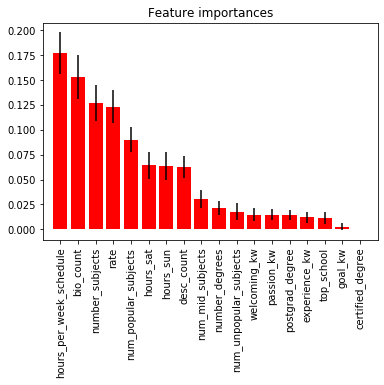

In [70]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0,  min_samples_leaf = 5)
features = list(X.columns)
rf.fit(X, y_log)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [71]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)
features = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
perm.fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1621 ± 0.0218,hours_per_week_schedule
0.1060 ± 0.0368,number_subjects
0.0608 ± 0.0085,rate
0.0581 ± 0.0089,bio_count
0.0426 ± 0.0176,num_popular_subjects
0.0231 ± 0.0096,hours_sat
0.0224 ± 0.0049,hours_sun
0.0193 ± 0.0067,desc_count
0.0101 ± 0.0064,num_mid_subjects
0.0099 ± 0.0083,num_unpopular_subjects


In [72]:
# List of important features, amalgamated from feature importances calculated above
important_features = ['hours_per_week_schedule', 'bio_count', 'rate', 'number_subjects', 'welcoming_kw', 'desc_count',
                     'num_popular_subjects', 'experience_kw', 'postgrad_degree']

### Pivot to classification

In [104]:
# Use 2 hours/week as the rough estimate for median demand

label_high = (df_eng.hours_per_week_estimate > 2)
label_low = (df_eng.hours_per_week_estimate <= 2)
df_eng.loc[label_high, 'Label'] = 'High'
df_eng.loc[label_low, 'Label'] = 'Low'

In [105]:
# Check that classes are not imbalanced

imbalance = df_eng.Label.describe().freq / len(df_eng.Label)
print(imbalance)

0.5289009497964722


#### drop unnecessary columns, create features X and target y

In [103]:
X.columns

Index(['rate', 'hours_sun', 'hours_sat', 'hours_per_week_schedule',
       'number_subjects', 'number_degrees', 'experience_kw', 'welcoming_kw',
       'goal_kw', 'passion_kw', 'num_popular_subjects', 'num_mid_subjects',
       'num_unpopular_subjects', 'postgrad_degree', 'certified_degree',
       'top_school', 'bio_count', 'desc_count'],
      dtype='object')

In [96]:
cols_to_drop = ['descriptions', 'bio', 'subjects_list', 'subjects_emph_list', 
                'edu', 'bg_check_date', 'earliest_review_date', 
                'subjects_emph', 'subjects_all','hours_tutor', 
                'num_ratings', 'review_dates', 'earliest_date','undergrad_degree',
               'hours_mon', 'hours_tues', 'hours_wed', 'hours_thurs', 'hours_fri']

X = df_eng.drop(columns=(['hours_per_week_estimate', 'Label'] + cols_to_drop))
#rescale data
y = df_eng['Label']

In [97]:
# function returns cross-validation score for a given model, metric, and input data
def score_CV(model, data, metric):
    score = cross_val_score(model, data, y, cv=5, scoring=metric)
    print(metric, 'mean:', '%.2f'%np.mean(score))

### First try logistic regression as a baseline

accuracy mean: 0.62
roc_auc mean: 0.66


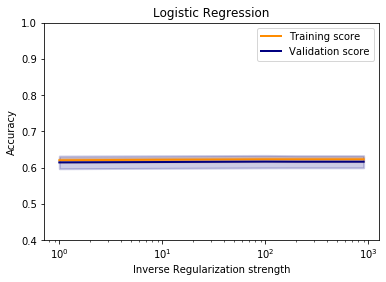

In [98]:
# Need to scale data for regression
X_scaled = (X - X.min()) / (X.max()-X.min())

logreg = LogisticRegression(solver='newton-cg', C=100)
score_CV(logreg, X_scaled, 'accuracy')
score_CV(logreg, X_scaled, 'roc_auc')

# Plot Validation Curve

param_range = np.arange(1,1000,100)
train_scores, valid_scores = validation_curve(logreg, X_scaled, y, 'C', param_range, cv=5)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Logistic Regression")
plt.xlabel('Inverse Regularization strength')
plt.ylabel("Accuracy")
plt.ylim(0.4, 1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Now do a Random Forest Classifier

accuracy mean: 0.70
roc_auc mean: 0.76


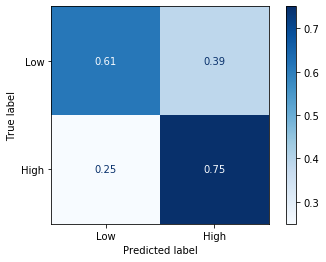

In [99]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf = 5, criterion='entropy', random_state=0)
score_CV(rf, X, 'accuracy')
score_CV(rf, X, 'roc_auc')

# Plot normalized confusion matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

y_predict = rf.predict(X_test)
y_fit = rf.predict(X_train)

disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=['Low', 'High'],
                             cmap=plt.cm.Blues,
                            normalize='true')
plt.show()

### Feature importances

Feature ranking:
feature hours_per_week_schedule (0.15)
feature bio_count (0.14)
feature number_subjects (0.12)
feature rate (0.11)
feature num_popular_subjects (0.10)
feature hours_sat (0.08)
feature hours_sun (0.07)
feature desc_count (0.07)
feature num_mid_subjects (0.04)
feature number_degrees (0.03)
feature welcoming_kw (0.02)
feature postgrad_degree (0.02)
feature passion_kw (0.02)
feature experience_kw (0.02)
feature top_school (0.01)
feature num_unpopular_subjects (0.01)
feature goal_kw (0.00)
feature certified_degree (0.00)


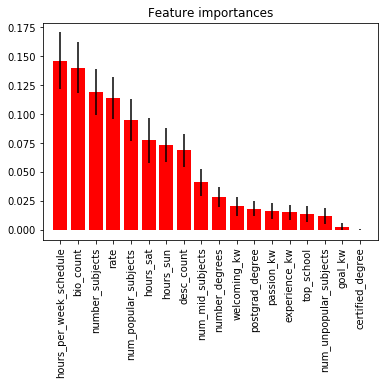

In [100]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0,  min_samples_leaf = 5)
features = list(X.columns)
rf.fit(X, y)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [101]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0, min_samples_leaf = 5)
features = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
perm.fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0621 ± 0.0200,hours_per_week_schedule
0.0404 ± 0.0137,rate
0.0323 ± 0.0167,number_subjects
0.0198 ± 0.0117,bio_count
0.0174 ± 0.0055,desc_count
0.0166 ± 0.0090,num_popular_subjects
0.0122 ± 0.0034,hours_sat
0.0122 ± 0.0057,hours_sun
0.0081 ± 0.0096,postgrad_degree
0.0060 ± 0.0090,num_mid_subjects


### Train RF classifier on subset of important features, see minimal decrease in AUC. 

accuracy mean: 0.69
roc_auc mean: 0.76


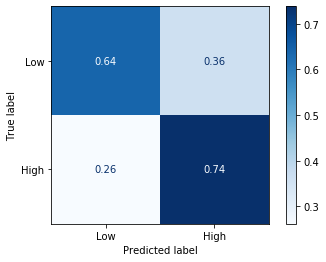

In [106]:
cols_important = ['number_subjects', 'hours_per_week_schedule', 'rate', 'bio_count', 'num_popular_subjects',
          'number_degrees', 'desc_count', 'welcoming_kw', 'passion_kw', 'experience_kw']

X_sub = X[cols_important]
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf = 5, criterion='entropy', random_state=0)
score_CV(rf, X_sub, 'accuracy')
score_CV(rf, X_sub, 'roc_auc')

# Plot confusion matrix
X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)
disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=['Low', 'High'],
                             cmap=plt.cm.Blues,
                            normalize='true')
plt.savefig('confusion-demand.png', dpi=100)
plt.show()

#### output final engineered dataset as csv

In [57]:
df_eng[cols_important + ['hours_per_week_estimate' , 'Label']].to_csv('/Users/NewUser/Documents/GitHub/tutor_prediction/tutor_prediction/data/tutor_data_demand.csv')